# Klasyfikacja niezbalansowana, klasyfikatory zespołowe i wyjaśnialna AI

## Wykorzystanie Google Colab

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/apohllo/sztuczna-inteligencja/blob/master/lab2/notebook_empty.ipynb)

## Ładowanie i eksploracja danych

Na tym laboratorium wykorzystamy zbiór danych [Polish companies bankruptcy](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data). Dotyczy on klasyfikacji, na podstawie danych z raportów finansowych, czy firma zbankrutuje w ciągu najbliższych kilku lat. Jest to zadanie szczególnie istotne dla banków, funduszy inwestycyjnych, firm ubezpieczeniowych itp., które z tego powodu zatrudniają licznie data scientistów. Zbiór zawiera 64 cechy, obliczone przez ekonomistów, którzy stworzyli ten zbiór, są one opisane na podlinkowanej wcześniej stronie. Dotyczą one zysków, posiadanych zasobów oraz długów firm.

Ściągnij i rozpakuj dane (`Data Folder` -> `data.zip`) do katalogu `data` obok tego notebooka. Znajduje się tam 5 plików w formacie `.arff`, wykorzystywanym głównie przez oprogramowanie Weka. Jest to program do "klikania" ML w interfejsie graficznym, jakiś czas temu popularny wśród mniej technicznych data scientistów. W Pythonie ładuje się je za pomocą bibliotek SciPy i Pandas.

W dalszej części laboratorium wykorzystamy plik `3year.arff`, w którym na podstawie finansowych firmy po 3 latach monitorowania chcemy przewidywać, czy firma zbankrutuje w ciągu najbliższych 3 lat. Jest to dość realistyczny horyzont czasowy.

In [2]:
%pip install pandas scikit-learn matplotlib missingno imbalanced-learn lightgbm shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
from scipy.io import arff
import pandas as pd

data = arff.loadarff(os.path.join("data", "3year.arff"))
X = pd.DataFrame(data[0])

Przyjrzyjmy się teraz naszym danym.

In [4]:
X.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,b'0'
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,b'0'
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,b'0'
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,b'0'
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,b'0'


In [5]:
X.dtypes

Attr1     float64
Attr2     float64
Attr3     float64
Attr4     float64
Attr5     float64
           ...   
Attr61    float64
Attr62    float64
Attr63    float64
Attr64    float64
class      object
Length: 65, dtype: object

In [6]:
X.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,10503.000000,10503.000000,10503.000000,10485.000000,1.047800e+04,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,...,1.050300e+04,10460.000000,10503.000000,10474.000000,10503.000000,9.911000e+03,10486.000000,1.046000e+04,10485.000000,10275.000000
mean,0.052844,0.619911,0.095490,9.980499,-1.347662e+03,-0.121159,0.065624,19.140113,1.819254,0.366093,...,6.638549e+03,-0.530082,-0.014817,3.848794,1.429319,5.713363e+02,13.935361,1.355370e+02,9.095149,35.766800
std,0.647797,6.427041,6.420056,523.691951,1.185806e+05,6.970625,0.651152,717.756745,7.581659,6.428603,...,5.989196e+04,55.978608,18.684047,190.201224,77.273270,3.715967e+04,83.704103,2.599116e+04,31.419096,428.298315
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,...,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102
25%,0.000686,0.253955,0.017461,1.040100,-5.207075e+01,0.000000,0.002118,0.431270,1.011275,0.297340,...,1.462100e+01,0.005137,0.006796,0.875560,0.000000,5.533150e+00,4.486075,4.073700e+01,3.062800,2.023350
50%,0.043034,0.464140,0.198560,1.605600,1.579300e+00,0.000000,0.050945,1.111000,1.199000,0.515500,...,8.822900e+02,0.051765,0.106880,0.953060,0.002976,9.952100e+00,6.677300,7.066400e+01,5.139200,4.059300
75%,0.123805,0.689330,0.419545,2.959500,5.608400e+01,0.072584,0.142275,2.857100,2.059100,0.725635,...,4.348900e+03,0.130010,0.271310,0.995927,0.240320,2.093600e+01,10.587500,1.182200e+02,8.882600,9.682750
max,52.652000,480.730000,17.708000,53433.000000,6.854400e+05,45.533000,52.652000,53432.000000,740.440000,11.837000,...,3.380500e+06,293.150000,552.640000,18118.000000,7617.300000,3.660200e+06,4470.400000,1.073500e+06,1974.500000,21499.000000


DataFrame zawiera 64 atrybuty numeryczne o zróżnicowanych rozkładach wartości oraz kolumnę `"class"` typu `bytes` z klasami 0 i 1.

**Zadanie 1 (0.25 punktu)**

Wyodrębnij klasy jako osobną zmienną typu `pd.Series`. Dokonaj konwersji typu na liczby całkowite.

In [7]:
data_class = pd.Series(data=X["class"], dtype="int")
data_class.describe()

count    10503.000000
mean         0.047129
std          0.211926
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: class, dtype: float64

Wiemy, że mamy do czynienia z klasyfikacją binarną - klasa 0 to brak bankructwa, klasa 1 to bankructwo w ciągu najbliższych 3 lat. Przyjrzyjmy się dokładniej naszym danym.

**Zadanie 2 (0.5 punktu)**

Narysuj wykres słupkowy (bar plot) częstotliwości obu klas w całym zbiorze. Upewnij się, że na osi X są numery lub nazwy klas, a oś Y ma wartości w procentach.

Dodatkowo wypisz częstotliwość każdej klasy w procentach.

<BarContainer object of 2 artists>

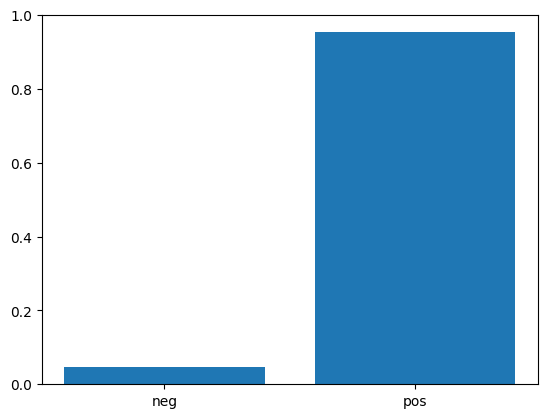

In [8]:
import matplotlib.pyplot as plt
pos = data_class[data_class == 1]
neg = data_class[data_class == 0]
plt.bar(["neg", "pos"], [pos.size / data_class.size, neg.size / data_class.size])

Jak widać, klasa pozytywna jest w znacznej mniejszości, stanowi poniżej 5% zbioru. Taki problem nazywamy **klasyfikacją niezbalansowaną (imbalanced classification)**. Mamy tu **klasę dominującą (majority class)** oraz **klasę mniejszościową (minority class)**. Pechowo prawie zawsze interesuje nas ta druga, bo klasa większościowa jest trywialna. Przykładowo, 99% badanych jest zdrowych, a 1% ma niewykryty nowotwór - z oczywistych przyczyn chcemy wykrywać właśnie sytuację rzadką (problem diagnozy jako klasyfikacji jest zasadniczo zawsze niezbalansowany). W dalszej części laboratorium poznamy szereg konsekwencji tego zjawiska i metody na radzenie sobie z nim.

Mamy sporo cech, wszystkie numeryczne. Ciekawe, czy mają wartości brakujące, a jeśli tak, to ile. Można to policzyć, ale wykres jest często czytelniejszy. Pomoże nam tu biblioteka `missingno`. Zaznacza ona w każdej kolumnie wartości brakujące przeciwnym kolorem.

<AxesSubplot: >

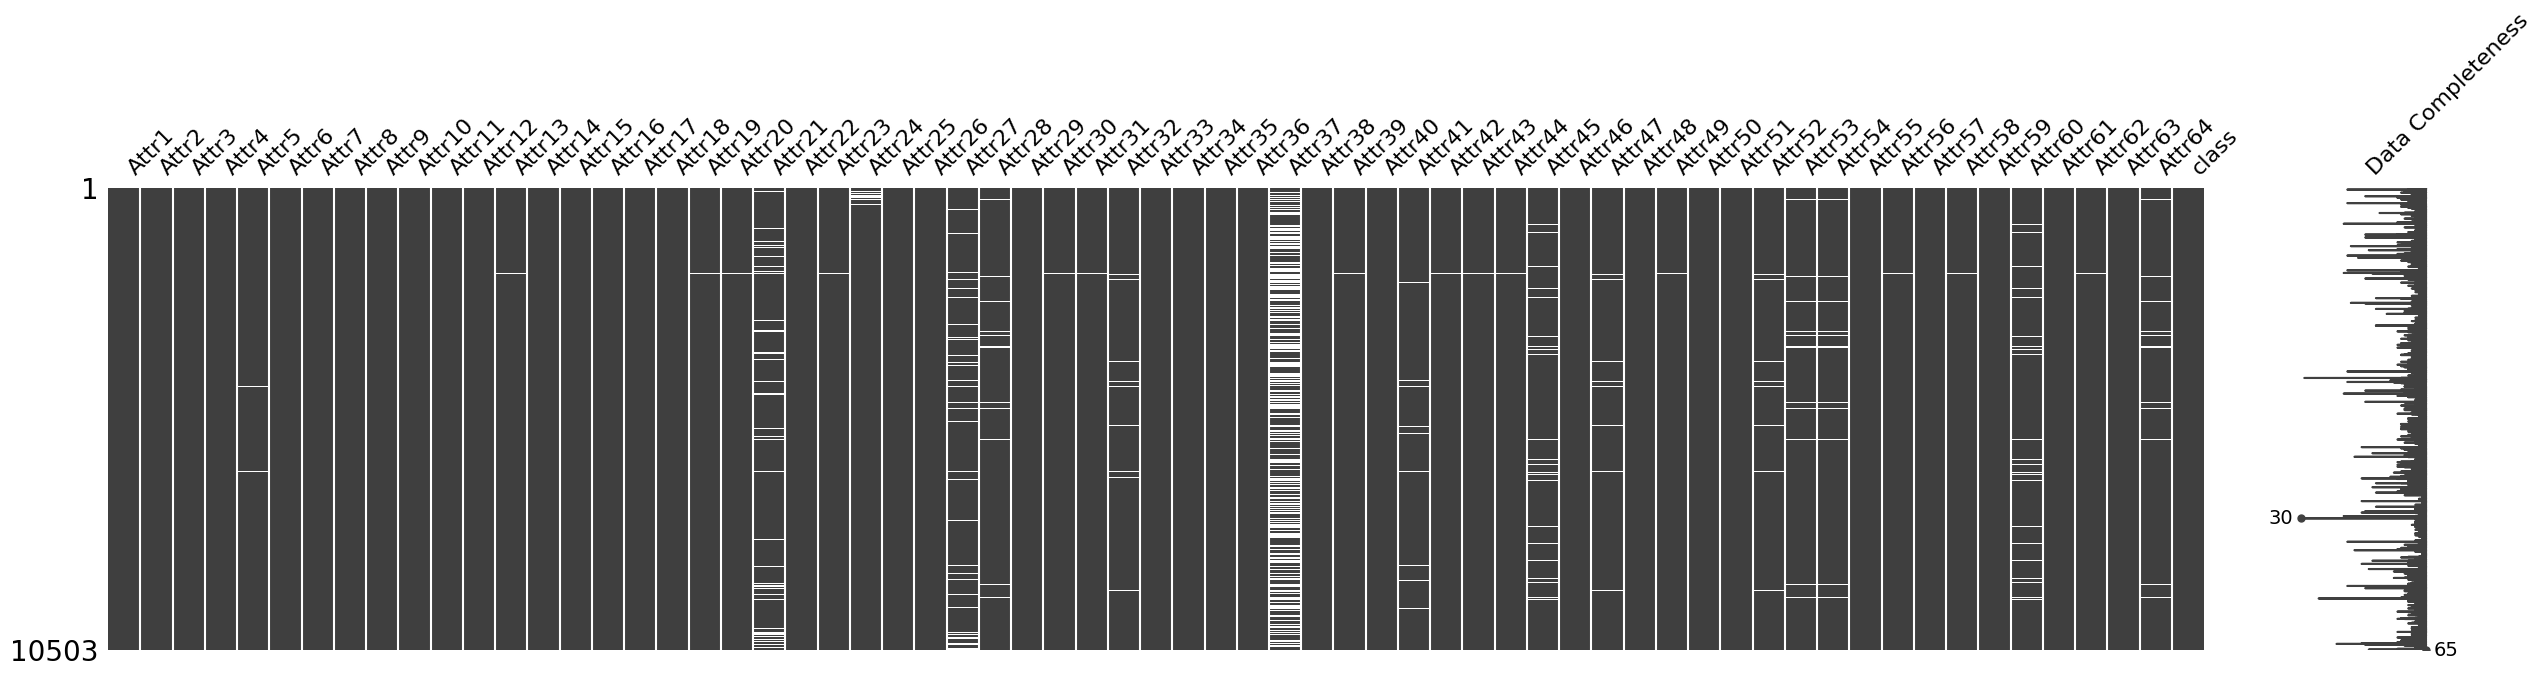

In [9]:
import missingno as msno

msno.matrix(X, labels=True, figsize=(30, 6))

Jak widać, cecha 37 ma bardzo dużo wartości brakujących, podczas gdy pozostałe cechy mają raczej niewielką ich liczbę. W takiej sytuacji najlepiej usunąć tę cechę, a pozostałe wartości brakujące **uzupełnić / imputować (impute)**. Typowo wykorzystuje się do tego wartość średnią lub medianę z danej kolumny. Ale uwaga - imputacji dokonuje się dopiero po podziale na zbiór treningowy i testowy! W przeciwnym wypadku wykorzystywalibyśmy dane ze zbioru testowego, co sztucznie zawyżyłoby wyniki. Jest to błąd metodologiczny - **wyciek danych (data leakage)**.

**Zadanie 3 (0.25 punktu)**

Usuń kolumnę `"Attr37"` ze zbioru danych.

In [10]:
X = X.drop(columns=["Attr37"])

Podział na zbiór treningowy i testowy to pierwszy moment, kiedy niezbalansowanie danych nam przeszkadza. Jeżeli zrobimy to czysto losowo, to są spore szanse, że w zbiorze testowym będzie tylko klasa negatywna - w końcu jest jej aż >95%. Dlatego wykorzystuje się **próbkowanie ze stratyfikacją (stratified sampling)**, dzięki któremu proporcje klas w zbiorze przed podziałem oraz obu zbiorach po podziale są takie same.

**Zadanie 4 (0.5 punktu)**

Dokonaj podziału zbioru na treningowy i testowy w proporcjach 80%-20%, ze stratyfikacją, wykorzystując funkcję `train_test_split` ze Scikit-learn'a. Przemieszaj zbiór (`shuffle`), ale pamiętaj o uwzględnieniu stałego `random_state`, aby wyniki były **reprodukowalne (reproducible)**. Zwróć uwagę, że w Scikit-learn'ie argument `stratify` oczekuje wektora klas.

In [11]:
from sklearn.model_selection import train_test_split

x = X.drop(inplace=False, columns=["class"])
y =  X["class"]

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=0, stratify=y
)

y_train = y_train.astype("int")
y_test = y_test.astype("int")

**Zadanie 5 (0.5 punktu)**

Uzupełnij wartości brakujące średnią wartością cechy. Użyj do tego klasy `SimpleImputer`. Pamiętaj, aby obliczyć wartość średnią na zbiorze treningowym (`.fit()`), a przetransformować później oba zbiory (`X_train`, `X_test`).

In [12]:
from sklearn.impute import SimpleImputer
inputer = SimpleImputer(strategy="mean")
inputer.fit(X_train)

cols = X.columns[X.columns != "class"]

X_train = pd.DataFrame(inputer.transform(X_train))
X_test = pd.DataFrame(inputer.transform(X_test))

X_train.columns = cols
X_test.columns = cols

## Prosta klasyfikacja

Zanim przejdzie się do modeli bardziej złożonych, trzeba najpierw wypróbować coś prostego, żeby mieć punkt odniesienia. Tworzy się dlatego **modele bazowe (baselines)**.

W naszym przypadku będzie to **drzewo decyzyjne (decision tree)**. Jest to drzewo binarne z decyzjami if-else, prowadzącymi do klasyfikacji danego przykładu w liściu. Każdy podział w drzewie to pytanie postaci "Czy wartość cechy X jest większa lub równa Y?". Trening takiego drzewa to prosty algorytm zachłanny, bardzo przypomina budowę zwykłego drzewa binarnego. W każdym węźle wykonujemy:
1. Sprawdź po kolei wszystkie możliwe punkty podziału, czyli każdą (unikalną) wartość każdej cechy, po kolei.
2. Dla każdego przypadku podziel zbiór na 2 kawałki: niespełniający warunku (lewe dziecko) i spełniający warunek (prawe dziecko).
3. Oblicz jakość podziału według pewnej wybranej funkcji jakości. Im lepiej nasz if/else rozdziela klasy od siebie (im "czystsze" są węzły-dzieci), tym wyższa jakość. Innymi słowy, chcemy, żeby do jednego dziecka poszła jedna klasa, a do drugiego druga.
4. Wybierz podział o najwyższej jakości.

Taki algorytm wykonuje się rekurencyjnie, aż otrzymamy węzeł czysty (pure leaf), czyli taki, w którym są przykłady z tylko jednej klasy. Typowo wykorzystywaną funkcją jakości (kryterium podziału) jest entropia Shannona - im niższa entropia, tym bardziej jednolite są klasy w węźle (czyli wybieramy podział o najniższej entropii).

Powyższe wytłumaczenie algorytmu jest oczywiście nieformalne i dość skrótowe. Doskonałe tłumaczenie, z interaktywnymi wizualizacjami, dostępne jest [tutaj](https://mlu-explain.github.io/decision-tree/). W formie filmów - [tutaj](https://www.youtube.com/watch?v=ZVR2Way4nwQ) oraz [tutaj](https://www.youtube.com/watch?v=_L39rN6gz7Y). Dla drzew do regresji - [ten film](https://www.youtube.com/watch?v=g9c66TUylZ4).

<img src = https://miro.medium.com/max/1838/1*WyTsLwcAXivFCgNtF0OPqA.png width = "642" height = "451" >

Warto zauważyć, że taka konstrukcja prowadzi zawsze do overfittingu. Otrzymanie liści czystych oznacza, że mamy 100% dokładności na zbiorze treningowym, czyli perfekcyjnie przeuczony klasyfikator. W związku z tym nasze predykcje mają bardzo niski bias, ale bardzo dużą wariancję. Pomimo tego drzewa potrafią dać bardzo przyzwoite wyniki, a w celu ich poprawy można je regularyzować, aby mieć mniej "rozrośnięte" drzewo. [Film dla zainteresowanych](https://www.youtube.com/watch?v=D0efHEJsfHo).

W tym wypadku AI to naprawdę tylko zbiór if'ów ;)

**Zadanie 6 (0.5 punktu)**

Wytrenuj klasyfikator drzewa decyzyjnego (klasa `DecisionTreeClassifier`). Użyj entropii jako kryterium podziału. Pamiętaj o użyciu stałego `random_state`.

In [13]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion="entropy", random_state=0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

Teraz musimy sprawdzić jakość naszego baseline'u. Tu kolejny problem z klasyfikacją niezbalansowaną - zwykła celność (accuracy) na pewno nie zadziała! Typowo wykorzystuje się AUC, nazywane też AUROC (Area Under Receiver Operating Characteristic), bo metryka ta "widzi" i uwzględnia niezbalansowanie klas. Wymaga ona przekazania prawdopodobieństwa klasy pozytywnej, a nie tylko binarnej decyzji.

Bardzo dobre i bardziej szczegółowe wytłumaczenie, z interktywnymi wizualizacjami, można znaleć [tutaj](https://mlu-explain.github.io/roc-auc/). Dla preferujących filmy - [tutaj](https://www.youtube.com/watch?v=4jRBRDbJemM).

Użyj do tego metody `.predict_proba()`, która w kolejnych kolumnach zwraca prawdopodobieństwa poszczególnych klas (nas interesuje kolumna 1).

**Zadanie 7 (0.5 punktu)**

Oblicz i wypisz AUROC na zbiorze testowym dla drzewa decyzyjnego (funkcja `roc_auc_score`). Skomentuj wynik - czy jest to twoim zdaniem dużo czy mało? Weź pod uwagę możliwy zakres wartości tej metryki.

In [14]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1])

0.7266899766899767

Na pewno jest możliwość lepszego dopasowania - score ~0.72 jest bliżej klasyfikatora losowego (0.5) niż perfekcyjnego (1.0)

## Uczenie zespołowe, bagging, lasy losowe

Bardzo często wiele klasyfikatorów działających razem daje lepsze wyniki niż pojedynczy klasyfikator. Takie podejście nazywa się **uczeniem zespołowym (ensemble learning)**. Istnieje wiele różnych podejść do tworzenia takich klasyfikatorów złożonych (ensemble classifiers).

Podstawową metodą jest **bagging**:
1. Wylosuj N (np. 100, 500, ...) próbek boostrapowych (boostrap sample) ze zbioru treningowego. Próbka boostrapowa to po prostu losowanie ze zwracaniem, gdzie dla wejściowego zbioru z M wierszami losujemy M próbek. Będą tam powtórzenia, średnio nawet 1/3, ale się tym nie przejmujemy.
2. Wytrenuj klasyfikator bazowy (base classifier) na każdej z próbek boostrapowych.
3. Stwórz klasyfikator złożony poprzez uśrednienie predykcji każdego z klasyfikatorów bazowych.

<img src = https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Ensemble_Bagging.svg/440px-Ensemble_Bagging.svg.png width = "440" height = "248" >

Typowo klasyfikatory bazowe są bardzo proste, żeby można było szybko wytrenować ich dużą liczbę. Prawie zawsze używa się do tego drzew decyzyjnych. Dla klasyfikacji uśrednienie wyników polega na głosowaniu - dla nowej próbki każdy klasyfikator bazowy ją klasyfikuje, sumuje się głosy na każdą klasę i zwraca najbardziej popularną decyzję.

Taki sposób ensemblingu zmniejsza wariancję klasyfikatora. Intuicyjnie, skoro coś uśredniamy, to siłą rzeczy będzie mniej rozrzucone, bo dużo ciężej będzie osiągnąć jakąś skrajność. Redukuje to też overfitting.

**Lasy losowe (Random Forests)** to ulepszenie baggingu. Zaobserwowano, że pomimo losowania próbek boostrapowych, w baggingu poszczególne drzewa są do siebie bardzo podobne (są skorelowane), używają podobnych cech ze zbioru. My natomiast chcemy zróżnicowania, żeby mieć niski bias - redukcją wariancji zajmuje się uśrednianie. Dlatego używa się metody losowej podprzestrzeni (random subspace method) - przy każdym podziale drzewa losuje się tylko pewien podzbiór cech, których możemy użyć do tego podziału. Typowo jest to pierwiastek kwadratowy z ogólnej liczby cech.

Zarówno bagging, jak i lasy losowe mają dodatkowo bardzo przyjemną własność - są mało czułe na hiperparametry, szczególnie na liczbę drzew. W praktyce wystarczy ustawić 500 czy 1000 drzew i będzie dobrze działać. Dalsze dostrajanie hiperparametrów może jeszcze trochę poprawić wyniki, ale nie tak bardzo, jak przy innych klasyfikatorach. Jest to zatem doskonały wybór domyślny, kiedy nie wiemy, jakiego klasyfikatora użyć.

Dodatkowo jest to problem **embarassingly parallel** - drzewa można trenować w 100% równolegle, dzięki czemu jest to dodatkowo wydajna obliczeniowo metoda.

Głębsze wytłumaczenie, z interaktywnymi wizualizacjami, można znaleźć [tutaj](https://mlu-explain.github.io/random-forest/). Dobrze tłumaczy je też [ta seria filmów](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&t=480s).

**Zadanie 8 (0.5 punktu)**

Wytrenuj klasyfikator Random Forest (klasa `RandomForestClassifier`). Użyj 500 drzew i entropii jako kryterium podziału. Pamiętaj, aby ustawić stały `random_state`. Dla przyspieszenia ustaw `n_jobs=-1` (użyje tylu procesów, ile masz dostępnych rdzeni procesora). Następnie sprawdź jego jakość na zbiorze testowym. Skomentuj wynik w odniesieniu do baseline'u.

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=-1, random_state=0)
rf_classifier.fit(X_train, y_train)

roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:,1])

0.8994111948657404

Otrzymany score jest znacznie lepszy od pojedynczego drzewa decyzyjnego

Wynik ten możemy jednak jeszcze ulepszyć!

## Oversampling, SMOTE

W przypadku zbiorów niezbalansowanych można dokonać **balansowania (balancing)** zbioru. Są tutaj 2 metody:
- **undersampling**: usunięcie przykładów z klasy dominującej
- **oversampling**: wygenerowanie dodatkowych przykładów z klasy mniejszościowej

Undersampling działa dobrze, kiedy niezbalansowanie jest niewielkie, a zbiór jest duży (możemy sobie pozwolić na usunięcie jego części). Oversampling typowo daje lepsze wyniki, istnieją dla niego bardzo efektywne algorytmy. W przypadku bardzo dużego niezbalansowania można zrobić oba.

Typowym algorytmem oversamplingu jest **SMOTE (Synthetic Minority Oversampling TEchnique)**. Działa on następująco:
1. Idź po kolei po przykładach z klasy mniejszościowej
2. Znajdź `k` najbliższych przykładów dla próbki, typowo `k=5`
3. Wylosuj tylu sąsiadów, ile trzeba do oversamplingu, np. jeżeli chcemy zwiększyć klasę mniejszościową 3 razy (o 200%), to wylosuj 2 z 5 sąsiadów
4. Dla każdego z wylosowanych sąsiadów wylosuj punkt na linii prostej między próbką a tym sąsiadem. Dodaj ten punkt jako nową próbkę do zbioru

<img src = https://miro.medium.com/max/734/1*yRumRhn89acByodBz0H7oA.png >

Taka technika generuje przykłady bardzo podobne do prawdziwych, więc nie zaburza zbioru, a jednocześnie pomaga klasyfikatorom, bo "zagęszcza" przestrzeń, w której znajduje się klasa pozytywna.

Algorytm SMOTE, jego warianty i inne algorytmy dla problemów niezbalansowanych implementuje biblioteka Imbalanced-learn.

**Zadanie 9 (1 punkt)**

Użyj SMOTE do zbalansowania zbioru treningowego (nie używa się go na zbiorze testowym!) (klasa `SMOTE`). Wytrenuj drzewo decyzyjne oraz las losowy na zbalansowanym zbiorze, użyj tych samych argumentów co wcześniej. Pamiętaj o użyciu wszędzie stałego `random_state` i `n_jobs=-1`. Skomentuj wynik.

In [16]:
from imblearn.over_sampling import SMOTE

balancer = SMOTE(random_state=0, n_jobs=-1)
X_train_resampled, y_train_resampled = balancer.fit_resample(X_train, y_train)

resampled_dt = DecisionTreeClassifier(criterion="entropy", random_state=0)
resampled_dt.fit(X_train_resampled, y_train_resampled)

resampled_rt = RandomForestClassifier(n_estimators=500, criterion="entropy", random_state=0, n_jobs=-1)
resampled_rt.fit(X_train_resampled, y_train_resampled)

dt_score = roc_auc_score(y_test, resampled_dt.predict_proba(X_test)[:,1])
rt_score = roc_auc_score(y_test, resampled_rt.predict_proba(X_test)[:,1])
print(f"DecisionTree: {dt_score}\t\tRandomTree: {rt_score}")

DecisionTree: 0.70995670995671		RandomTree: 0.9047644274917003


W przypadku pojedynczego drzewa decyzyjnego score się nieznacznie pomniejszył, a dla losowych drzew polepszył o bardzo małą ilość.

W dalszej części laboratorium używaj zbioru po zastosowaniu SMOTE do treningu klasyfikatorów.s

## Dostrajanie (tuning) hiperparametrów

Lasy losowe są stosunkowo mało czułe na dobór hiperparametrów - i dobrze, bo mają ich dość dużo. Można zawsze jednak spróbować to zrobić, a w szczególności najważniejszy jest parametr `max_features`, oznaczający, ile cech losować przy każdym podziale drzewa. Typowo sprawdza się wartości z zakresu `[0.1, 0.5]`.

W kwestii szybkości, kiedy dostrajamy hiperparametry, to mniej oczywiste jest, jakiego `n_jobs` użyć. Z jednej strony klasyfikator może być trenowany na wielu procesach, a z drugiej można trenować wiele klasyfikatorów na różnych zestawach hiperparametrów równolegle. Jeżeli nasz klasyfikator bardzo dobrze się uwspółbieżnia (jak Random Forest), to można dać mu nawet wszystkie rdzenie, a za to wypróbowywać kolejne zestawy hiperparametrów sekwencyjnie. Warto ustawić parametr `verbose` na 2 lub więcej, żeby dostać logi podczas długiego treningu i mierzyć czas wykonania. W praktyce ustawia się to metodą prób i błędów.

**Zadanie 10 (1 punkt)**

Wykorzystaj grid search z cross validation z 5 foldami, aby dobrać wartość `max_features` (klasa `GridSearchCV`). Wypróbuj wartości `[0.1, 0.2, 0.3, 0.4, 0.5]`

Pamiętaj, żeby jako estymatora przekazanego do grid search'a użyć instancji Random Forest, która ma już ustawione `random_state` i `n_jobs`. Wybierz model o najwyższym AUROC - jako `scoring` przekaż "roc_auc".

Skomentuj wynik. Czy warto było poświęcić czas i zasoby na tę procedurę?

In [17]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

rf_estimator = RandomForestClassifier(criterion="entropy", n_estimators=500, random_state=0, n_jobs=-1)

folds = KFold(n_splits=5, shuffle=True, random_state=0)
hyper_params = {"max_features": [.1, .2, .3, .4, .5]}

selector = GridSearchCV(
    estimator=rf_estimator,
    param_grid=hyper_params,
    scoring="roc_auc",
    cv=folds,
    verbose=2,
    return_train_score=True
)

selector.fit(X_train_resampled, y_train_resampled)
selector.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...................................max_features=0.1; total time=   5.0s
[CV] END ...................................max_features=0.1; total time=   3.5s
[CV] END ...................................max_features=0.1; total time=   3.5s
[CV] END ...................................max_features=0.1; total time=   3.5s
[CV] END ...................................max_features=0.1; total time=   3.6s
[CV] END ...................................max_features=0.2; total time=   6.1s
[CV] END ...................................max_features=0.2; total time=   6.1s
[CV] END ...................................max_features=0.2; total time=   6.1s
[CV] END ...................................max_features=0.2; total time=   6.0s
[CV] END ...................................max_features=0.2; total time=   6.3s
[CV] END ...................................max_features=0.3; total time=   8.7s
[CV] END ...................................max_f

{'max_features': 0.2}

In [18]:
rf_estimator_best = RandomForestClassifier(criterion="entropy", n_estimators=500, max_features=.2, random_state=0, n_jobs=-1)
rf_estimator_best.fit(X_train_resampled, y_train_resampled)
roc_auc_score(y_test, rf_estimator_best.predict_proba(X_test)[:,1])

0.9122619804437986

Poprawa wyniku jest rzędu 0.01 - rzeczywiście sprawdza się mała czułość algorytmu na hiperparametr `max_features`

W praktycznych zastosowaniach data scientist wedle własnego uznana, doświadczenia, dostępnego czasu i zasobów wybiera, czy dostrajać hiperparametry i w jak szerokim zakresie. Dla Random Forest na szczęście często może nie być znaczącej potrzeby, i za to go lubimy :)

**Zadanie 11 (0.25 punktu)**

Sprawdź, jaka była optymalna wartość `max_features`. Jest to atrybut wytrenowanego `GridSearchCV`.

In [19]:
selector.best_params_

{'max_features': 0.2}

**Random Forest - podsumowanie**

1. Model oparty o uczenie zespołowe
2. Kluczowe elementy:
   - bagging: uczenie wielu klasyfikatorów na próbkach boostrapowych
   - metoda losowej podprzestrzeni: losujemy podzbiór cech do każdego podziału drzewa
   - uśredniamy głosy klasyfikatorów
3. Dość odporny na overfitting, zmniejsza wariancję błędu dzięki uśrednianiu
4. Mało czuły na hiperparametry
5. Przeciętnie bardzo dobre wyniki, doskonały wybór domyślny przy wybieraniu algorytmu klasyfikacji

## Boosting

Drugą bardzo ważną grupą algorytmów ensemblingu jest **boosting**, też oparty o drzewa decyzyjne. O ile Random Forest trenował wszystkie klasyfikatory bazowe równolegle i je uśredniał, o tyle boosting robi to sekwencyjnie. Drzewa te uczą się na całym zbiorze, nie na próbkach boostrapowych. Idea jest następująca: trenujemy drzewo decyzyjne, radzi sobie przeciętnie i popełnia błędy na częsci przykładów treningowych. Dokładamy kolejne, ale znające błędy swojego poprzednika, dzięki czemu może to uwzględnić i je poprawić. W związku z tym "boostuje" się dzięki wiedzy od poprzednika. Dokładamy kolejne drzewa zgodnie z tą samą zasadą.

Jak uczyć się na błędach poprzednika? Jest to pewna **funkcja kosztu** (błędu), którą chcemy zminimalizować. Zakłada się jakąś jej konkretną postać, np. squared error dla regresji, albo logistic loss dla klasyfikacji. Później wykorzystuje się spadek wzdłuż gradientu (gradient descent), aby nauczyć się, w jakim kierunku powinny optymalizować kolejne drzewa, żeby zminimalizować błędy poprzednika. Jest to konkretnie **gradient boosting**, absolutnie najpopularniejsza forma boostingu, i jeden z najpopularniejszych i osiągających najlepsze wyniki algorytmów ML.

Tyle co do intuicji. Ogólny algorytm gradient boostingu jest trochę bardziej skomplikowany. Bardzo dobrze i krok po kroku tłumaczy go [ta seria filmów na YT](https://www.youtube.com/watch?v=3CC4N4z3GJc). Szczególnie ważne implementacje gradient boostingu to **XGBoost (Extreme Gradient Boosting)** oraz **LightGBM (Light Gradient Boosting Machine)**. XGBoost był prawdziwym przełomem w ML, uzyskując doskonałe wyniki i bardzo dobrze się skalując - był wykorzystany w CERNie do wykrywania cząstki Higgsa w zbiorze z pomiarów LHC mającym 10 milionów próbek. Jego implementacja jest dość złożona, ale dobrze tłumaczy ją [inna seria filmików na YT](https://www.youtube.com/watch?v=OtD8wVaFm6E).

![](xgboost.png)

Obecnie najczęściej wykorzystuje się LightGBM. Został stworzony przez Microsoft na podstawie doświadczeń z XGBoostem. Został jeszcze bardziej ulepszony i przyspieszony, ale różnice są głównie implementacyjne. Różnice dobrze tłumaczy [ta prezentacja z konferencji PyData](https://www.youtube.com/watch?v=5CWwwtEM2TA) oraz [prezentacja Microsoftu](https://www.youtube.com/watch?v=5nKSMXBFhes). Dla zainteresowanych - [praktyczne aspekty LightGBM](https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python/notebook).

**Zadanie 12 (0.75 punktu)**

Wytrenuj klasyfikator LightGBM (klasa `LGBMClassifier`), sprawdź jego AUROC na zbiorze testowym. Pamiętaj o `random_state` i `n_jobs`. Skomentuj wynik w odniesieniu do wcześniejszych algorytmów.

In [20]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=500, random_state=0, n_jobs=-1)
lgbm.fit(X_train_resampled, y_train_resampled)
roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])

0.9527442254714982

Nawet bez tuningu hiperparametrów score jest lepszy niż najlepszy z poprzednich. Możliwe, że jest to "lucky shot" w dobre hiperparametry?

Boosting dzięki uczeniu na poprzednich drzewach redukuje nie tylko wariancję, ale też bias w błędzie, dzięki czemu może w wielu przypadkach osiągnąć lepsze rezultaty od lasu losowego. Do tego dzięki znakomitej implementacji LightGBM jest szybszy.

Boosting jest jednak o wiele bardziej czuły na hiperparametry niż Random Forest. W szczególności bardzo łatwo go przeuczyć, a większość hiperparametrów, których jest dużo, wiąże się z regularyzacją modelu. To, że teraz poszło nam lepiej z domyślnymi, jest rzadkim przypadkiem.

W związku z tym, że przestrzeń hiperparametrów jest duża, przeszukanie wszystkich kombinacji nie wchodzi w grę. Zamiast tego można wylosować zadaną liczbę zestawów hiperparametrów i tylko je sprawdzić - chociaż im więcej, tym lepsze wyniki powinniśmy dostać. Służy do tego `RandomizedSearchCV`. Co więcej, klasa ta potrafi próbkować rozkłady prawdopodobieństwa, a nie tylko sztywne listy wartości, co jest bardzo przydatne przy parametrach ciągłych.

Hiperparametry LightGBMa są dobrze opisane w oficjalnej dokumentacji: [wersja krótsza](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier) i [wersja dłuższa](https://lightgbm.readthedocs.io/en/latest/Parameters.html). Jest ich dużo, więc nie będziemy ich tutaj omawiać. Jeżeli chodzi o ich dostrajanie w praktyce, to przydatny jest [oficjalny guide](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) oraz dyskusje na Kaggle.

**Zadanie 13 (1 punkt)**

Zaimplementuj random search dla LightGBMa (klasa `RandomizedSearchCV`). Użyj tylu prób, na ile pozwalają twoje zasoby obliczeniowe, ale przynajmniej 30. Przeszukaj przestrzeń hiperparametrów:
```
param_grid = {
    "n_estimators": [400, 500, 600],
    "learning_rate": [0.05, 0.1, 0.2],
    "num_leaves": [31, 48, 64],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "subsample": [0.8, 0.9, 1.0],
}
```
Na koniec wypisz znalezione optymalne hiperparametry.

Pamiętaj o ustawieniu `random_state` i `n_jobs`, oraz ewentualnie `verbose` dla śledzenia przebiegu. Skomentuj wynik, szczególnie w odniesieniu do LightGBMa bez dostrajania hiperparametrów.

In [21]:
from sklearn.model_selection import RandomizedSearchCV

estimator = LGBMClassifier(random_state=0, n_jobs=-1)

param_grid = {
    "n_estimators": [400, 500, 600],
    "learning_rate": [0.05, 0.1, 0.2],
    "num_leaves": [31, 48, 64],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "subsample": [0.8, 0.9, 1.0],
}

rscv = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=0,
    n_iter=100
)
rscv.fit(X_train_resampled, y_train_resampled)
rscv.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'subsample': 0.8,
 'num_leaves': 31,
 'n_estimators': 600,
 'learning_rate': 0.2,
 'colsample_bytree': 1.0}

In [22]:
best_lgbm = LGBMClassifier(n_estimators=600,
                           subsample=.8,
                           num_leaves=31,
                           learning_rate=.2,
                           colsample_bytree=1.0,
                           random_state=0,
                           n_jobs=-1)

best_lgbm.fit(X_train_resampled, y_train_resampled)
roc_auc_score(y_test, best_lgbm.predict_proba(X_test)[:,1])

0.9467804922350377

Wynik nieco niższy niż z parametrami domyślnymi - czy parametry domyślne akurat trafiły się bardziej optymalne dla naszego datasetu?

Powyżej sprawdziliśmy tylko jedną metrykę. Może jednak nowe hiperparametry wpłynęły też na inne metryki, być może nawet w bardziej znaczący sposób?

**Zadanie 14 (0.75 punktu)**

Wypisz raporty z klasyfikacji (funkcja `classification_report`), dla modelu LightGBM bez i z dostrajaniem hiperparametrów. Skomentuj różnicę precyzji (precision) i czułości (recall) między tymi modelami. Czy jest to pożądane zjawisko?

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lgbm.predict(X_test)))
print(classification_report(y_test, best_lgbm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2002
           1       0.76      0.55      0.64        99

    accuracy                           0.97      2101
   macro avg       0.87      0.77      0.81      2101
weighted avg       0.97      0.97      0.97      2101

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2002
           1       0.80      0.54      0.64        99

    accuracy                           0.97      2101
   macro avg       0.89      0.76      0.81      2101
weighted avg       0.97      0.97      0.97      2101



// skomentuj tutaj

**Boosting - podsumowanie**

1. Model oparty o uczenie zespołowe
2. Kolejne modele są dodawane sekwencyjnie i uczą się na błędach poprzedników
3. Nauka typowo jest oparta o minimalizację funkcji kosztu (błędu), z użyciem spadku wzdłuż gradientu
4. Wiodący model klasyfikacji dla danych tabelarycznych, z 2 głównymi implementacjami: XGBoost i LightGBM
5. Liczne hiperparametry, wymagające odpowiednich metod dostrajania

## Wyjaśnialna AI

W ostatnich latach zaczęto zwracać coraz większą uwagę na wpływ sztucznej inteligencji na społeczeństwo, a na niektórych czołowych konferencjach ML nawet obowiązkowa jest sekcja "Social impact" w artykułach naukowych. Typowo im lepszy model, tym bardziej złożony, a najpopularniejsze modele boostingu są z natury skomplikowane. Kiedy mają podejmować krytyczne decyzje, to musimy wiedzieć, czemu predykcja jest taka, a nie inna. Jest to poddziedzina uczenia maszynowego - **wyjaśnialna AI (explainable AI, XAI)**.

W szczególności interesująca jest tutaj **lokalna interpretowalność (local interpretability)** - zrozumienie, czemu dla konkretnej próbki model klasyfikuje ją tak, a nie inaczej. Chcemy uzyskać wiedzę, jakie wartości cech tej próbki miały najmniejszy / największy wpływ na taką decyzję. Dodatkowo trzeba wziąć pod uwagę interakcje między cechami, oraz samą charakterystykę modelu i to, jak wykorzystuje on te cechy. Jak widać, problem jest trudny.

Najpopularniejszym podejściem jest tutaj **SHAP (SHapley Additive exPlanations)**, metoda oparta o kooperatywną teorię gier. Traktuje się cechy modelu jak zbiór graczy, podzielonych na dwie drużyny (koalicje): jedna chce zaklasyfikować próbkę jako negatywną, a druga jako pozytywną. O ostatecznej decyzji decyduje model, który wykorzystuje te wartości cech. Powstaje pytanie - w jakim stopniu wartości cech przyczyniły się do wyniku swojej drużyny? Można to obliczyć jako wartości Shapleya (Shapley values), które dla modeli ML oblicza algorytm SHAP. Ma on bardzo znaczące, udowodnione matematycznie zalety, a dodatkowo posiada wyjątkowo efektywną implementację dla modeli drzewiastych oraz dobre wizualizacje.

Bardzo intuicyjnie, na prostym przykładzie, SHAPa wyjaśnia [pierwsza część tego artykułu](https://iancovert.com/blog/understanding-shap-sage/). Dobrze i dość szczegółówo SHAPa wyjaśnia jego autor [w tym filmie](https://www.youtube.com/watch?v=-taOhqkiuIo).

`TreeExplainer` służy do interpretacji modeli drzewiastych. Dostaje on, tak jak inne explainery SHAPa: model, dane treningowe, oraz rodzaj problemu (model output). W uproszczeniu jest to `"raw"` dla regresji albo `"probability"` dla klasyfikacji.

**Wypełnij w komórce poniżej odpowiednie zmienne**

In [26]:
%pip install ipywidgets

     -------------------------------------- 134.4/134.4 kB 2.6 MB/s eta 0:00:00
     -------------------------------------- 384.1/384.1 kB 8.1 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 7.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import shap

shap.initjs()

feature_names = ["net profit / total assets", "total liabilities / total assets", "working capital / total assets", "current assets / short-term liabilities", "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365", "retained earnings / total assets", "EBIT / total assets", "book value of equity / total liabilities", "sales / total assets", "equity / total assets", "(gross profit + extraordinary items + financial expenses) / total assets", "gross profit / short-term liabilities", "(gross profit + depreciation) / sales", "(gross profit + interest) / total assets", "(total liabilities * 365) / (gross profit + depreciation)", "(gross profit + depreciation) / total liabilities", "total assets / total liabilities", "gross profit / total assets", "gross profit / sales", "(inventory * 365) / sales", "sales (n) / sales (n-1)", "profit on operating activities / total assets", "net profit / sales", "gross profit (in 3 years) / total assets", "(equity - share capital) / total assets", "(net profit + depreciation) / total liabilities", "profit on operating activities / financial expenses", "working capital / fixed assets", "logarithm of total assets", "(total liabilities - cash) / sales", "(gross profit + interest) / sales", "(current liabilities * 365) / cost of products sold", "operating expenses / short-term liabilities", "operating expenses / total liabilities", "profit on sales / total assets", "total sales / total assets", "constant capital / total assets", "profit on sales / sales", "(current assets - inventory - receivables) / short-term liabilities", "total liabilities / ((profit on operating activities + depreciation) * (12/365))", "profit on operating activities / sales", "rotation receivables + inventory turnover in days", "(receivables * 365) / sales", "net profit / inventory", "(current assets - inventory) / short-term liabilities", "(inventory * 365) / cost of products sold", "EBITDA (profit on operating activities - depreciation) / total assets", "EBITDA (profit on operating activities - depreciation) / sales", "current assets / total liabilities", "short-term liabilities / total assets", "(short-term liabilities * 365) / cost of products sold)", "equity / fixed assets", "constant capital / fixed assets", "working capital", "(sales - cost of products sold) / sales", "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)", "total costs / total sales", "long-term liabilities / equity", "sales / inventory", "sales / receivables", "(short-term liabilities * 365) / sales", "sales / short-term liabilities", "sales / fixed assets"]

explainer = shap.TreeExplainer(
    model=best_lgbm,  # variable with trained, tuned LightGBM model
    data=X_train_resampled,   # variable with training data X, after resampling with SMOTE
    model_output="probability"
)

Teraz obliczymy wartości Shapleya dla wybranego przykładu ze zbioru testowego i narysujemy force plot. W tej wizualizacji bezpośrednio pokazujemy wielkość wpływu poszczególnych cech oraz ich wartości, a także to, w którą stronę pchają predykcję.

In [30]:
shap_values = explainer.shap_values(X_test.loc[0])

shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=X_test.loc[0],
    feature_names=feature_names
)

**Zadanie 15 (0.5 punktu)**

Dokonaj wyjaśnienia kolejnych 2 próbek z klasy pozytywnej i 2 z klasy negatywnej. Czy jakieś cechy są wyraźnie dominujące?

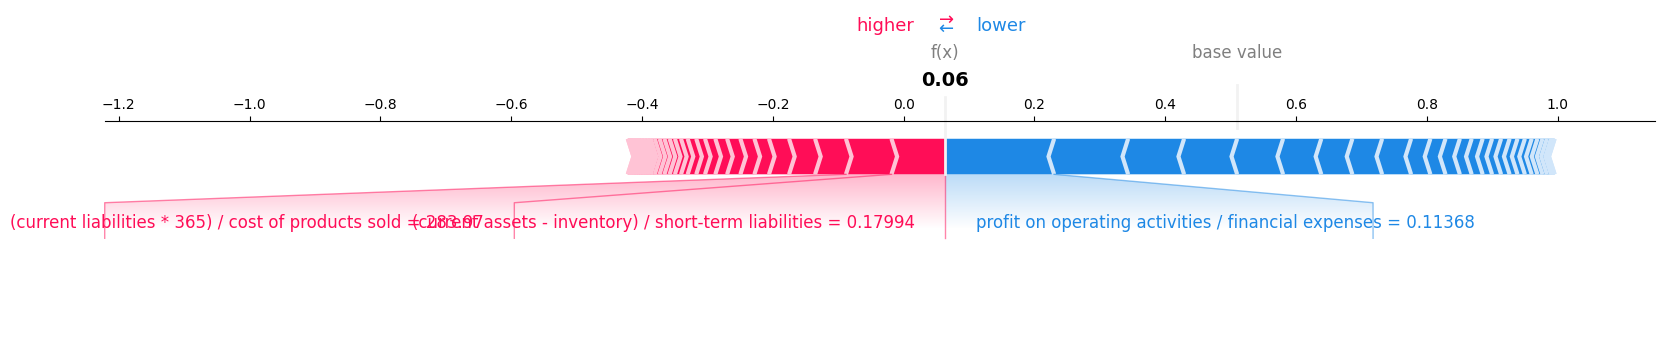

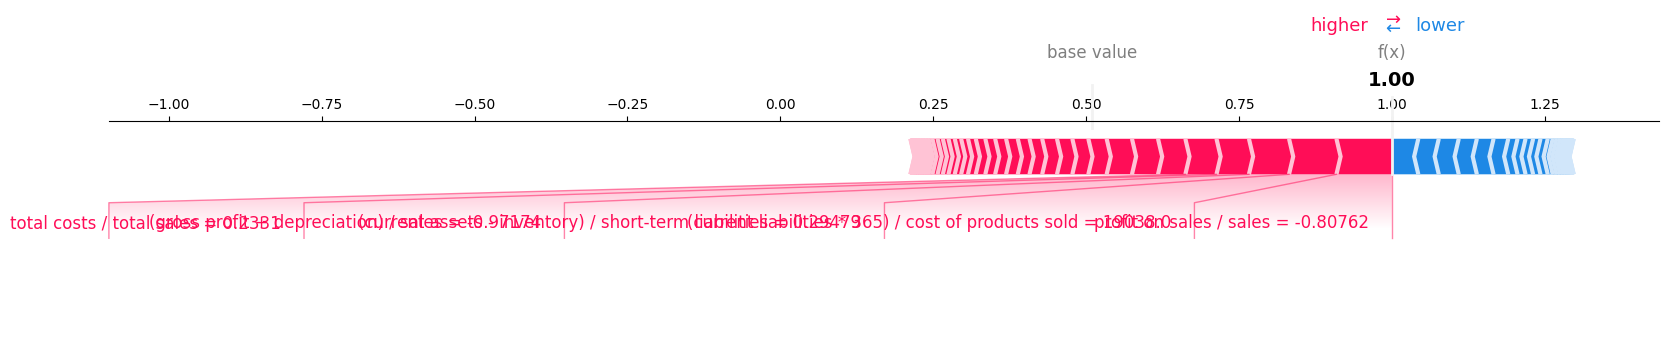

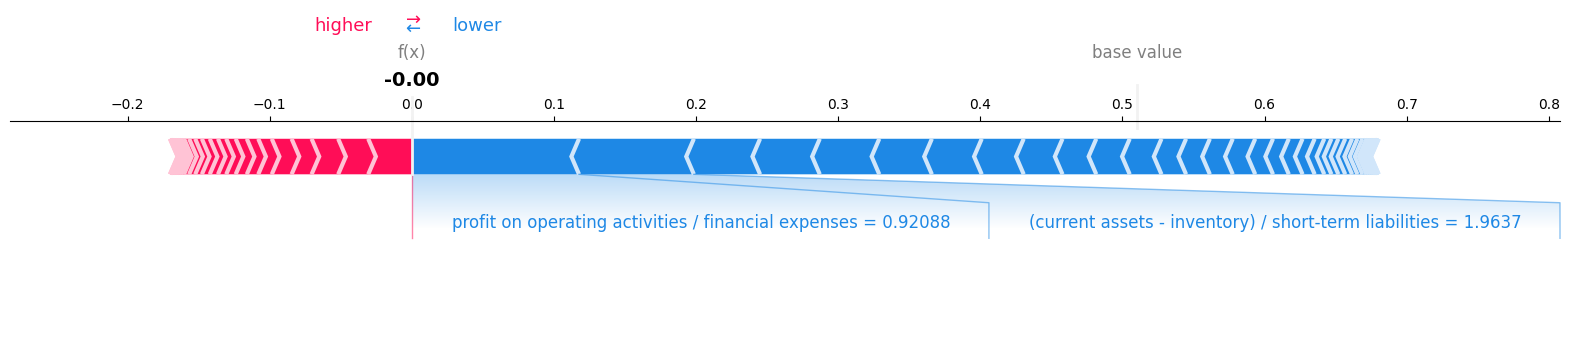

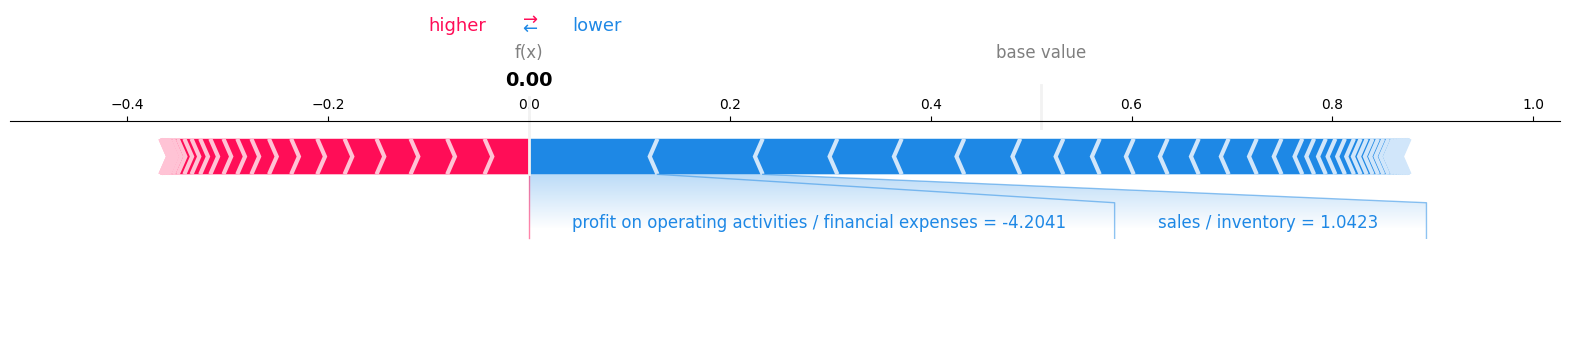

In [52]:
values = [
    X_test.loc[X_test.index[y_test == 1]].iloc[0],
    X_test.loc[X_test.index[y_test == 1]].iloc[1],
    X_test.loc[X_test.index[y_test == 0]].iloc[0],
    X_test.loc[X_test.index[y_test == 0]].iloc[1]
    ]

for v in values:
    shap.force_plot(base_value=explainer.expected_value,
                    shap_values=explainer.shap_values(v),
                    features=v,
                    feature_names=feature_names,
                    matplotlib=True) # does not render in a loop when JS-based for some reason

SHAP pozwala też na obliczenie **ważności cech (feature importances)**, czyli ogólnej wagi poszczególnych cech w całym zbiorze. Robi się to bardzo prosto - po prostu uśrednia się wartość bezwzględną Shapley value dla każdej cechy i przykładu ze zbioru treningowego.

Nasz zbiór po resamplingu jest dość duży, więc może to chwilę zająć. Jeżeli będzie trwało za długo, to użyj np. połowy danych.

100%|===================| 15968/16012 [05:56<00:00]        Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


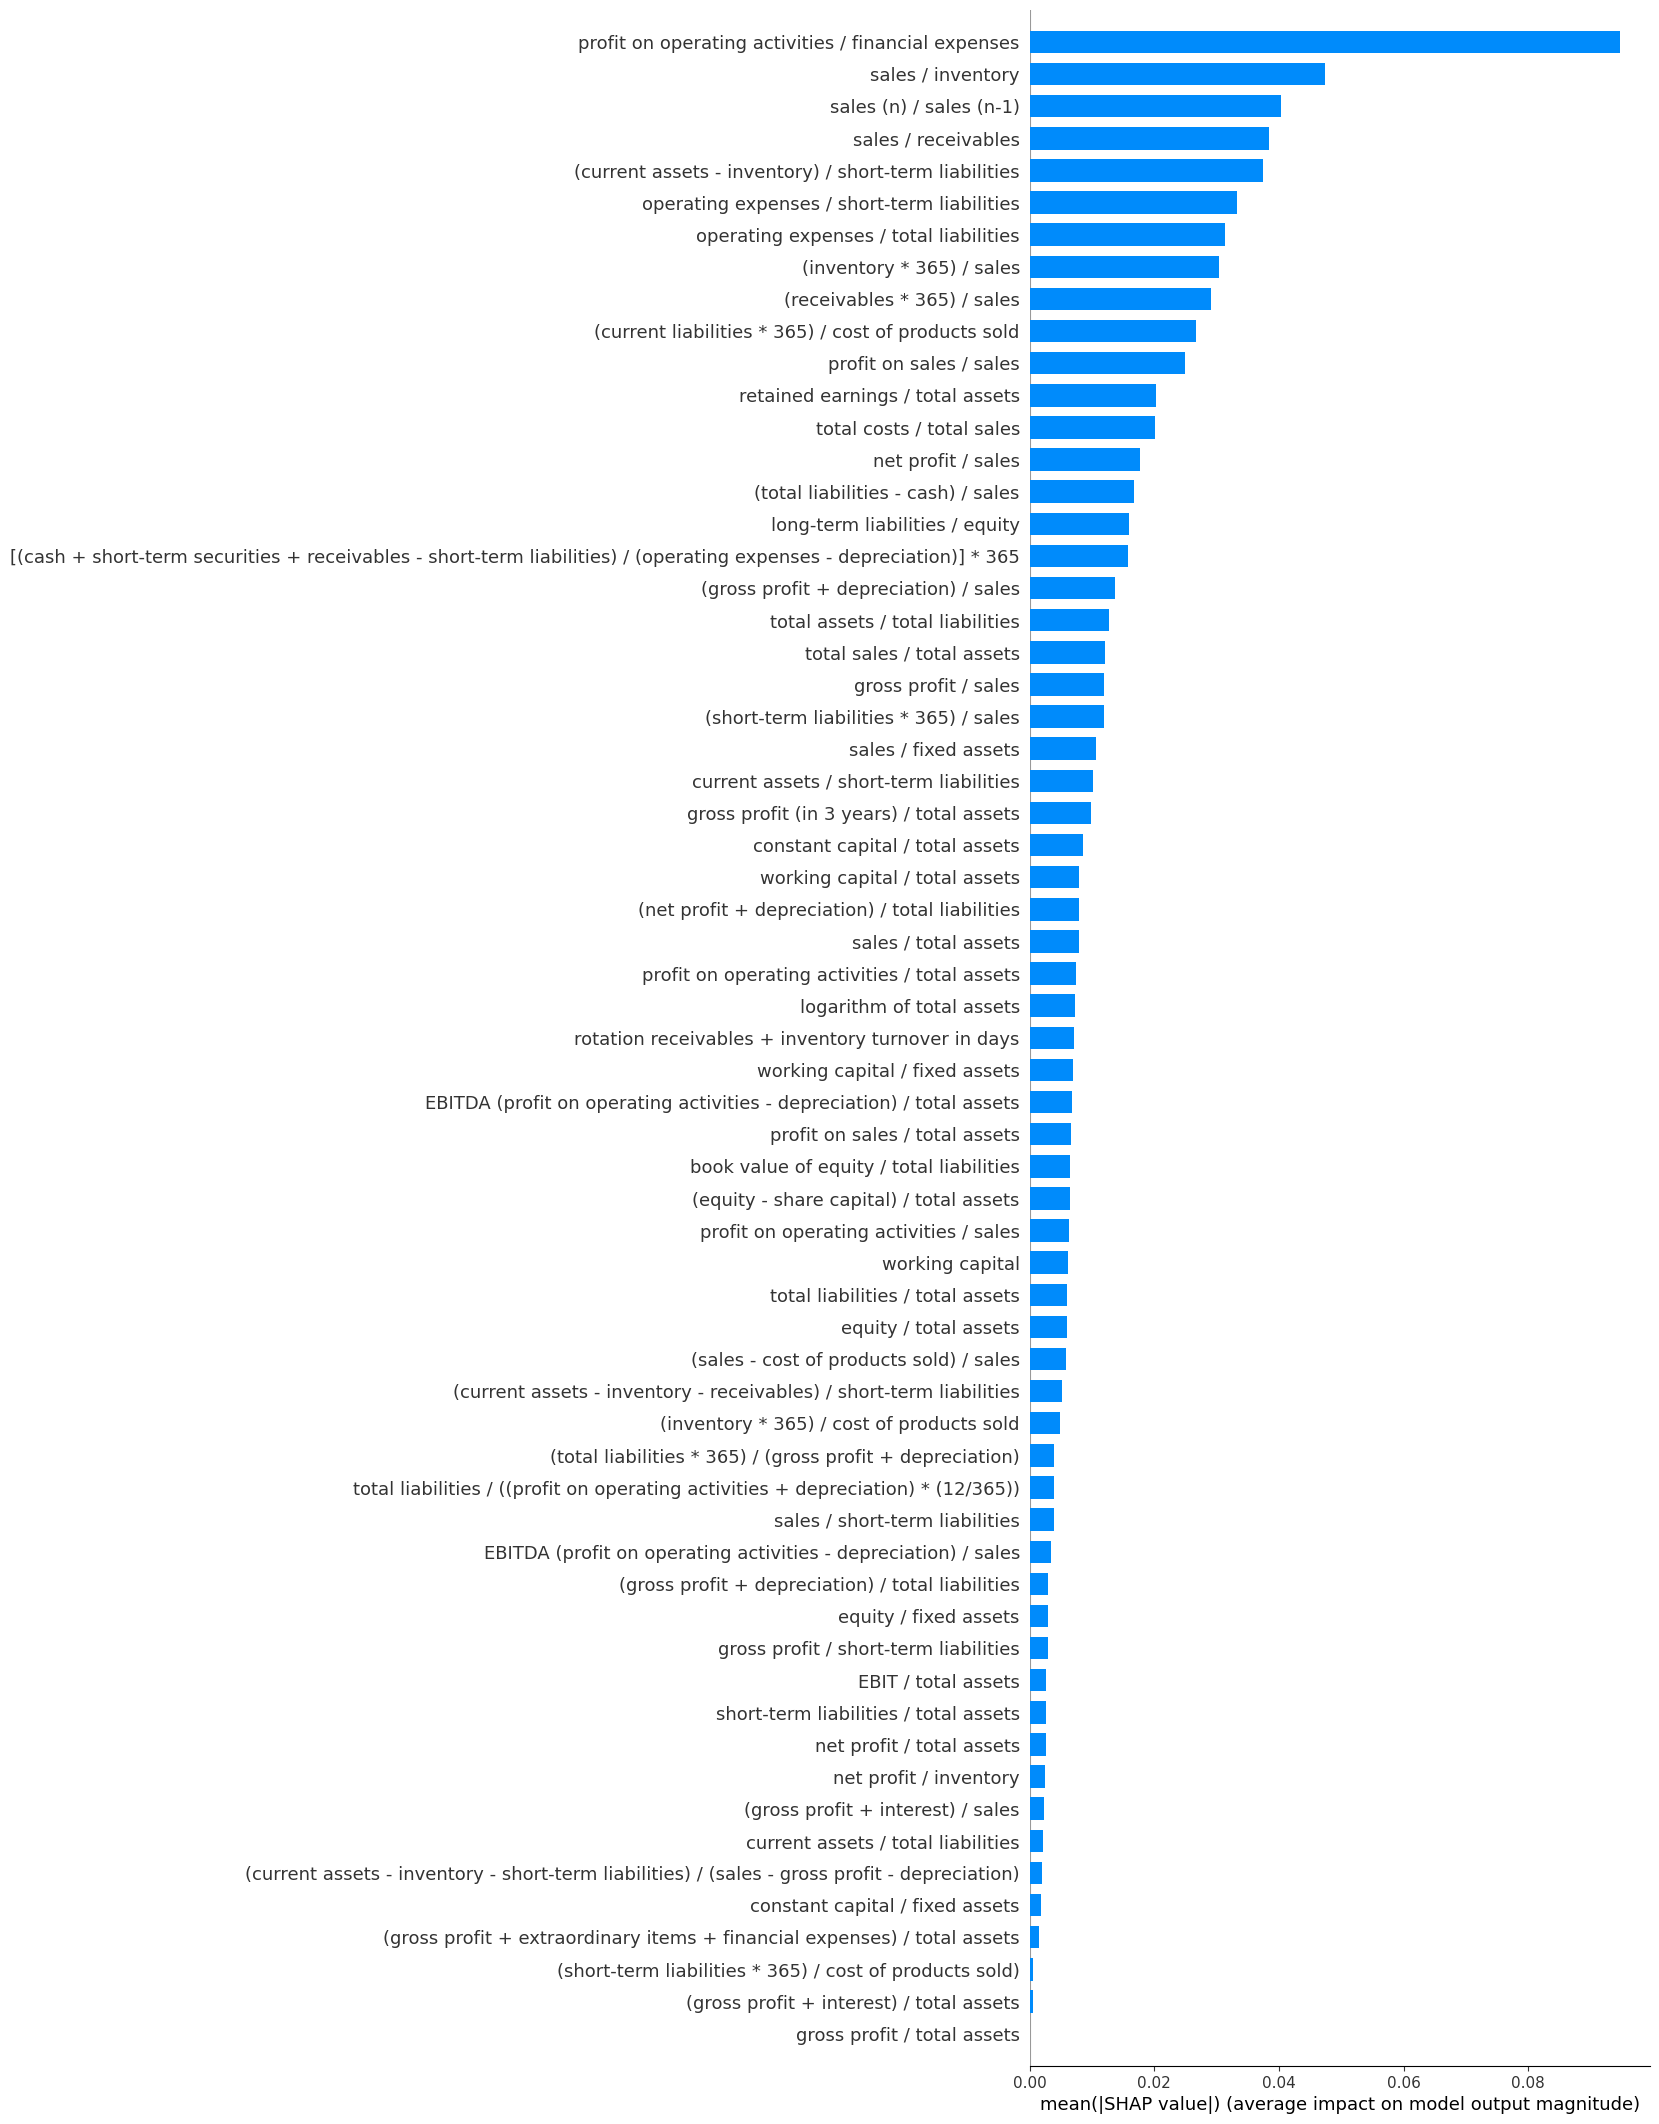

In [51]:
shap.summary_plot(
    shap_values=explainer.shap_values(X_train_resampled),
    features=X_train_resampled,
    feature_names=feature_names,
    max_display=X.shape[1],
    plot_type="bar",
)

Taka informacja jest cenna, bo dzięki temu lepiej wiemy, co robi model. Jest to ważne z kilku powodów:
1. Wymogi prawne - wdrażanie algorytmów w ekonomii, prawie etc. ma coraz częściej konkretne wymagania prawne co do wyjaśnialności predykcji
2. Dodatkowa wiedza dla użytkowników - często dodatkowe obserwacje co do próbek są ciekawe same w sobie i dają wiedzę użytkownikowi (często posiadającemu specjalistyczną wiedzę z dziedziny), czasem nawet bardziej niż sam model predykcyjny
3. Analiza modelu - dodatkowa wiedza o wewnętrznym działaniu algorytmu pozwala go lepiej zrozumieć i np. dokonać lepszego wyboru cech

**Wyjaśnialna AI - podsumowanie**

1. Problem zrozumienia, jak wnioskuje model i czemu podejmuje dane decyzje
2. Ważne zarówno z perspektywy data scientist'a, jak i użytkowników systemu
3. Można wyjaśniać model lokalnie (konkretne predykcje) lub globalnie (wpływ poszczególnych cech)
4. Wiodąca metoda interpretacji to SHAP, oparta o kooperacyjną teorię gier

## Pytania kontrolne (1.5 punktu)

1. Podaj inny przykład sytuacji klasyfikacji niezbalansowanej.
  - Klasyfikacja urządzeń w oparciu o różne cechy mechaniczne na posiadające/nie posiadające danej wady, w szczególności gdy dana wada jest rzadko spotykana.


2. Czy klasyfikacja niezbalansowana tyczy się tylko klasyfikacji binarnej?
  - Nie, nawet przy wielu klasach może zdarzyć się klasyfikacja niezbalansowana.


3. Załóżmy, że mamy stosunkowo duży zbiór danych. Co zrobiłbyś / zrobiłabyś z cechą, która ma:

  - a) 1% wartości brakujących, pozostałe cechy mają wszystkie wartości albo też ok. 1% braków
    - imputacja średnią/medianą

  - b) 10% wartości brakujących i ma rozkład normalny
    - regresja liniowa

  - c) 10% wartości brakujących i ma rozkład skośny

  - d) 50% wartości brakujących
    - usunąć cechę ze zbioru


4. Czy twoim zdaniem w regresji też możemy mieć problem niezbalansowania, tzn. regresję niezbalansowaną?
  - Przy regresji wynik jest ciągły, nie ma dyskretnych klas, więc raczej nie może wystąpić zjawisko klasy dominującej.


5. Czy masz pomysł, jak można by sobie poradzić z wartością brakującą w zmiennej kategorycznej (dyskretna, skończona, bez uporządkowania)?
  - Użyć klasyfikacji, np. drzewa decyzyjnego lub kNN


6. Drzewo decyzyjne o mniejszej maksymalnej głębokości jest słabiej, czy silniej zregularyzowane?
  - silniej zregularyzowane, gdyż mniejsza ilość decyzji zmniejszy możliwość overfittingu


7. Podaj 3 różnice między baggingiem (Random Forest) a boostingiem.
  - bagging jest _embarassingly parallel_, gdyż poszczególne instancje drzew nie są od siebie zależne, w przeciwieństwie do boostingu, gdzie wyniki poprzednich iteracji są wykorzystywane przez następne
  - w baggingu każda instancja korzysta z losowego podzbioru danych, a wyniki są uśredniane, a przy boostingu wykorzystywany jest cały dataset, a model dąży do minimalizacji wartości funkcji kosztu
  - Random Forest jest mało czły na hiperparametry, w przeciwieństwie do boostingu


8. Jak można by użyć informacji o globalnej ważności cech?
  - Pozwala to na przykład na selkcję cech i ew. odrzucenie cech nie mających wpływu na decyzję w celu optymalizacji
  - Może też ta informacja być przydatna "w realu", np. wiedza o cechach, które są najważniejsze dla obliczenia zdolności kredytowej przedsiębiorstwa pozwoli przedsiębiorcy wybrać, na czym się skupić aby polepszyć swoje szanse


## Zadanie dla chętnych

Dokonaj selekcji cech, usuwając 20% najsłabszych cech. Może się tu przydać klasa `SelectPercentile`. Czy Random Forest i LightGBM (bez dostrajania hiperparametrów, dla uproszczenia) wytrenowane bez najsłabszych cech dają lepszy wynik (AUROC lub innej metryki)?

Wykorzystaj po 1 algorytmie z 3 grup algorytmów selekcji cech:
1. Filter methods - mierzymy ważność każdej cechy niezależnie, za pomocą pewnej miary (typowo ze statystyki lub teorii informacji), a potem odrzucamy (filtrujemy) te o najniższej ważności. Są to np. `chi2` i `mutual_info_classif` z pakietu `sklearn.feature_selection`.
2. Embedded methods - klasyfikator sam zwraca ważność cech, jest jego wbudowaną cechą (stąd nazwa). Jest to w szczególności właściwość wszystkich zespołowych klasyfikatorów drzewiastych. Mają po wytrenowaniu atrybut `feature_importances_`.
2. Wrapper methods - algorytmy wykorzystujące w środku używany model (stąd nazwa), mierzące ważność cech za pomocą ich wpływu na jakość klasyfikatora. Jest to np. recursive feature elimination (klasa `RFE`). W tym algorytmie trenujemy klasyfikator na wszystkich cechach, wyrzucamy najsłabszą, trenujemy znowu i tak dalej.

Typowo metody filter są najszybsze, ale dają najsłabszy wynik, natomiast metody wrapper są najwolniejsze i dają najlepszy wynik. Metody embedded są gdzieś pośrodku.

Dla zainteresowanych, inne znane i bardzo dobre algorytmy:
- Relief (filter method) oraz warianty, szczególnie ReliefF, SURF i MultiSURF (biblioteka `ReBATE`): [Wikipedia](https://en.wikipedia.org/wiki/Relief_(feature_selection)), [artykuł "Benchmarking Relief-Based Feature Selection Methods"](https://www.researchgate.net/publication/321307194_Benchmarking_Relief-Based_Feature_Selection_Methods)
- Boruta (wrapper method), stworzony na Uniwersytecie Warszawskim, łączący Random Forest oraz testy statystyczne (biblioteka `boruta_py`): [link 1](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a), [link 2](https://danielhomola.com/feature%20selection/phd/borutapy-an-all-relevant-feature-selection-method/)